# Import

Example of journalling along with the codebase.

In [160]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error



In [565]:
from pint import UnitRegistry
# First we create the registry.
ureg = UnitRegistry()
#time = UnitRegistry()

# Then we append the new definitions
ureg.load_definitions('/Users/rv939730/Learn/DeepLearningHardware/DL_Papers_Summaries/myunits.txt') 
Q_ = ureg.Quantity


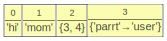

In [355]:
from lolviz import *
listviz(['hi','mom',{3,4},{"parrt":"user"}])
#g.view() # render and show graphviz.files.Source object


# SQL first priority -> Not used. Kept since code is developed

In [300]:
db = "/Users/rv939730/Learn/DeepLearningHardware/DL_Papers_Summaries/DL_Chips.db"

# DataFrames 

In [558]:
accelerator_df = pd.DataFrame([brainwave_demo])
accelerator_df = accelerator_df.append([brainwave])
accelerator_df = accelerator_df.set_index('name')


In [559]:
def change_dimension_float(series):
    if type(series["performance"]) != str:
        perf = float(series["performance"] * ureg.sec/ureg.teraops )
    else:
        perf = series["performance"]
    if type(series["power_eff"]) != str:
        pwr = float(series["power_eff"] * ureg.watt/ureg.gigaflops)
    else:
        pwr = series["power_eff"]
    print [perf,pwr]
    return [perf, pwr]

def change_dimension(series):
    if type(series["performance"]) != str:
        perf = series["performance"].to(ureg.teraops/ureg.sec)
    else:
        perf = series["performance"]
    if type(series["power_eff"]) != str:
        pwr = series["power_eff"].to(ureg.gigaflops/ureg.watt)
    else:
        pwr = series["power_eff"]
    print [perf,pwr]
    return [perf, pwr]

g = accelerator_df.apply(change_dimension, axis='columns')
accelerator_df["performance"] = [i[0] for i in g]
accelerator_df["power_eff"] = [i[1] for i in g]

[<Quantity(39.5, 'teraops / second')>, <Quantity(723, 'gigaflops / watt')>]
[<Quantity(90, 'teraops / second')>, 'NA']


In [560]:
accelerator_df

FPGAorASIC      frequency mac_count memory  \
name                                                        
brainwave_demo  stratix10  300 megahertz        NA     NA   
brainwave       stratix10  500 megahertz        NA     NA   

                          performance             power_eff processor_count  \
name                                                                          
brainwave_demo  39.5 teraops / second  723 gigaflops / watt              NA   
brainwave         90 teraops / second                    NA              NA   

               resolution transistor_count  
name                                        
brainwave_demo     MS-FP8               NA  
brainwave          MS-FP8               NA

# Microsoft Brainwave

While exploring a tabular dataset, how to find unique points ? 

Stratix10 280 has 5760 DSPs (11.5K 18x19 muls) + 930K ALMs. On dot products it can do (11.5K + 11.5K) x 0.5GHz =~12 TOPS

In [532]:
brainwave = {}
brainwave["name"] = "brainwave"
brainwave["performance"] = Q_(90,'teraops/s')
brainwave["power_eff"] = 'NA'
brainwave["resolution"] = 'MS-FP8'
brainwave["frequency"] = Q_(500,'MHz')
brainwave["memory"] = 'NA'
brainwave["mac_count"] =  'NA'
brainwave["transistor_count"] = 'NA'
brainwave["core_count"] = 'NA'
brainwave["FPGAorASIC"] = 'stratix10'
#dictviz(brainwave)
brainwave

{'FPGAorASIC': 'stratix10',
 'frequency': <Quantity(500, 'megahertz')>,
 'mac_count': 'NA',
 'memory': 'NA',
 'name': 'brainwave',
 'performance': <Quantity(90, 'teraops / second')>,
 'power_eff': 'NA',
 'processor_count': 'NA',
 'resolution': 'MS-FP8',
 'transistor_count': 'NA'}

In [533]:
brainwave_demo = {}
brainwave_demo["name"] = "brainwave_demo"
brainwave_demo["performance"] = Q_(39.5,'teraops/s')
brainwave_demo["power_eff"] = Q_(723, 'Gflops/W')
brainwave_demo["resolution"] = 'MS-FP8'
brainwave_demo["frequency"] = Q_(300,'MHz')
brainwave_demo["memory"] = 'NA'
brainwave_demo["mac_count"] =  'NA'
brainwave_demo["transistor_count"] = 'NA'
brainwave_demo["core_count"] = 'NA'
brainwave_demo["FPGAorASIC"] = 'stratix10'
#dictviz(brainwave)
brainwave_demo

{'FPGAorASIC': 'stratix10',
 'frequency': <Quantity(300, 'megahertz')>,
 'mac_count': 'NA',
 'memory': 'NA',
 'name': 'brainwave_demo',
 'performance': <Quantity(39.5, 'teraops / second')>,
 'power_eff': <Quantity(723, 'gigaflops / watt')>,
 'processor_count': 'NA',
 'resolution': 'MS-FP8',
 'transistor_count': 'NA'}

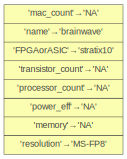

In [534]:
dictviz(brainwave)

In [105]:
#stratix10 = {}
#stratix10["dsp_count"] = Q_(5760,'count')
# 11.5* 1024* 18*19
FPGA = ('stratix10', '5760', 'NA');
conn_id = create_FPGA(conn, FPGA)

In [106]:
select_all_FPGAs(conn)

(1, u'stratix10', 5760, u'NA')


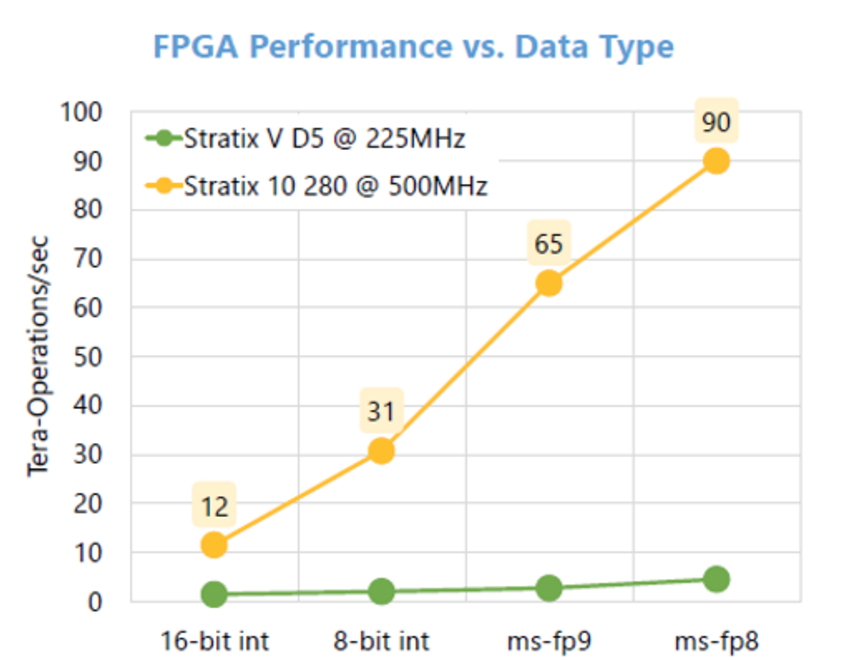

ms-fp8/fp9: Microsoft's "proprietary parameterizable narrow precision format": FPGA-efficient 8- and 9-bit floating point (?) formats. ms-fp9 at 65 TOPS and ms-fp8 at 90 TOPS at 0.5 GHz. Yesterday's demo was 39.5 TOPS at "130000/cycle" = ~300 MHz

You can do >1 short mul in one 18x19 DSP mul, but that won't get you to 65 or 90 TOPS (32 or 45 Tmul/s?). I think mostly LUT mul/adds

So it's fun to think what ms-fp8 might be. Separate sign or 2's comp? 5-6 bit mantissa? 2-3 bit exponent? Balance mul and add area.

Worst part of fp-add is denorm one operand to match exponents, then add, then norm the sum. Two barrel shifts = brutal in FPGAs.

For narrow exp dot products, no need. Sum terms a[i]*w[i] with a wide fixed point adder tree. FPGAs are sheer terrors at fixed pt add.

Anyway, after 25 years of FPGA reduced prec research, now have 'killer app': machine learning w/ 9-8-7-6-5-4-3-2b? weights/activations

With FPGAs there is / can be an everything bit numeric format. Or variable precision even in different operators of same type.

when Altera did 32b SP FPU-DSPs we asked designer ML how A might stretch to 64b DP (e.g. II=2 cycles). Now thinking <= 9b FPUs!

Parallelizing:

An RDMA-like protocol breaks messages into packets that can be spread across a pool of networked FPGAs within 10 microseconds. A single instruction can access 130,000 of Microsoft’s floating point operations in a cycle. The company declined to describe its fp format except to say it was not based on the IEEE standard.



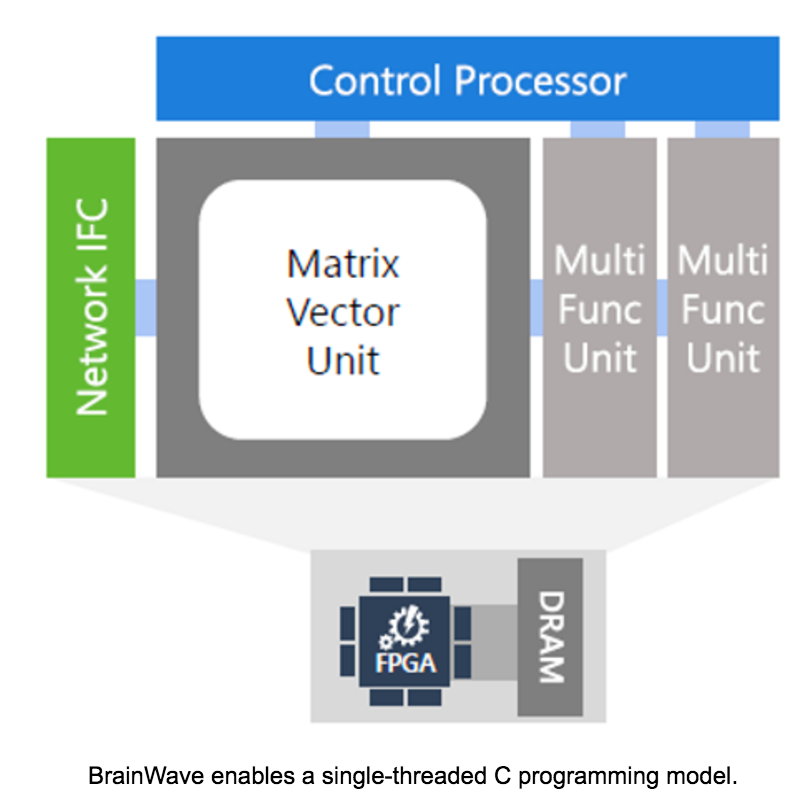

# Baidu XPU

Baidu: tiny cores are 1250 LUTs/4 DSP/5 BRAM, run at 600 MHz. >500 MHz in Xilinx is nontrivial. I've seen deep pipelining / MTA, limited result fwding/reg file bypass, and/or DSP datapath.

Recurrence: operand reg FF clk-out => ALU => result mux => result forwarding mux (regfile bypass) => operand reg FF setup is >2 ns.

DSP datapath soft prcoessors (NTU iDEA https://dr.ntu.edu.sg/handle/10220/16290?show=full … @sfahmy) lack full result fwding => reuse hazards in pipeline

Which can lead to lower IPC in compiled code. Note: no C compiler for Baidu tiny core -- use assembly.

That can be a reasonable approach and tradeoff vs. RTL but not as high productivity as "same C++ code runs on host or accelerator".

Anyway nice Baidu work validates a "software first, software mostly" path to making FPGA accelerators accessible to SW engineers.

# Nvidia Tesla

The Tesla P100 can deliver 21 TFLOPS of 16-bit floating point that is ideal for DNN applications. It employs CoWoS (Chip-on Wafer-on-Substrate) with HBM2 (high-bandwidth memory version 2) technology. AMD used HBM on its Radeon R9 GPU (see “Best of 2015: High Bandwidth Memory Helps GPU Deliver on Performance ” on electronicdesign.com). The Tesla P100 has four NVLinks, allowing multiple chips to be combined into a single compute node.



# Google TPU

Google got 20 percent better results having a neural net decide how to spread a graph compute problem over a pool of GPUs

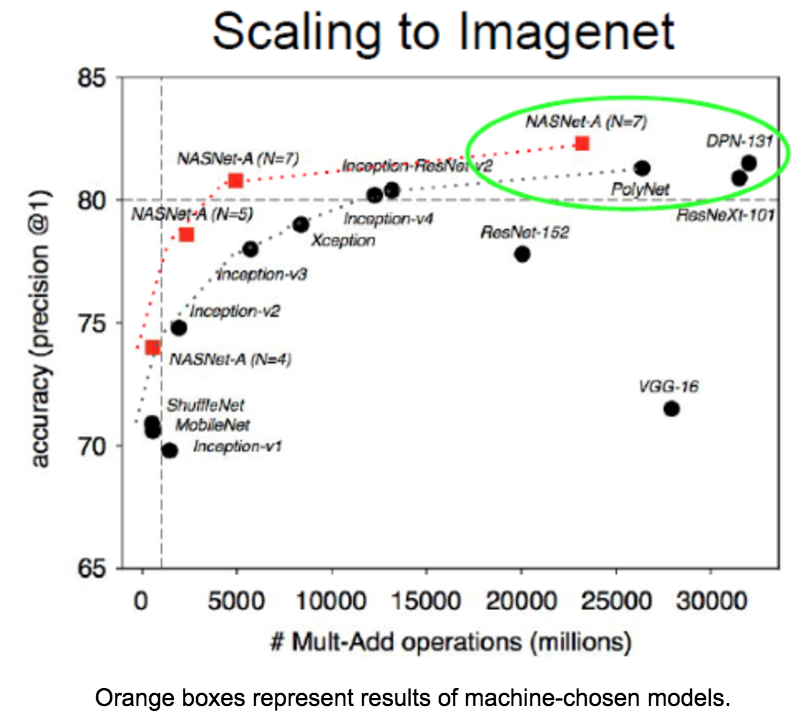

Parallelizing:

In addition, no one knows how to best create machines to process dynamic models across multiple boards. Developers still want batch sizes measured in millions, requiring new leaps in parallel training techniques.


Perhaps the trickiest bit is knowing what algorithms will be important in the next three or four years, he said.

“The field is moving extremely quickly. In a weekend we can design new optimization update rules. You have to make your best guess…[but] I’m pretty convinced we will end up in a pretty good state,” he said.



In [157]:
#performance_flops["TPU"] = 92 #Teraops/s
chip = ('TPU1', '92', 'NA', 'NA', 24, 64, 'NA','NA', 'ASIC');
chip_id = create_chip(conn, chip)

In [586]:
tpu1 = {}
tpu1["name"] = "tpu1"
tpu1["performance"] = Q_(92,'teraops/s')
tpu1["power_eff"] = "NA"
tpu1["resolution"] = '8-bit'
tpu1["frequency"] = "NA"
tpu1["memory"] = Q_(24,'megabytes')
tpu1["mac_count"] =  Q_(64,'kilomacs')
tpu1["transistor_count"] = 'NA'
tpu1["processor_count"] = 'NA'
tpu1["FPGAorASIC"] = 'ASIC'
#dictviz(brainwave)
tpu1

{'FPGAorASIC': 'ASIC',
 'frequency': 'NA',
 'mac_count': <Quantity(64, 'kilomacs')>,
 'memory': <Quantity(24, 'megabytes')>,
 'name': 'tpu1',
 'performance': <Quantity(92, 'teraops / second')>,
 'power_eff': 'NA',
 'processor_count': 'NA',
 'resolution': '8-bit',
 'transistor_count': 'NA'}

In [582]:
#performance_flops["brainwave"] = Q_(39.5,'teraops/s')
select_all_chips(conn)

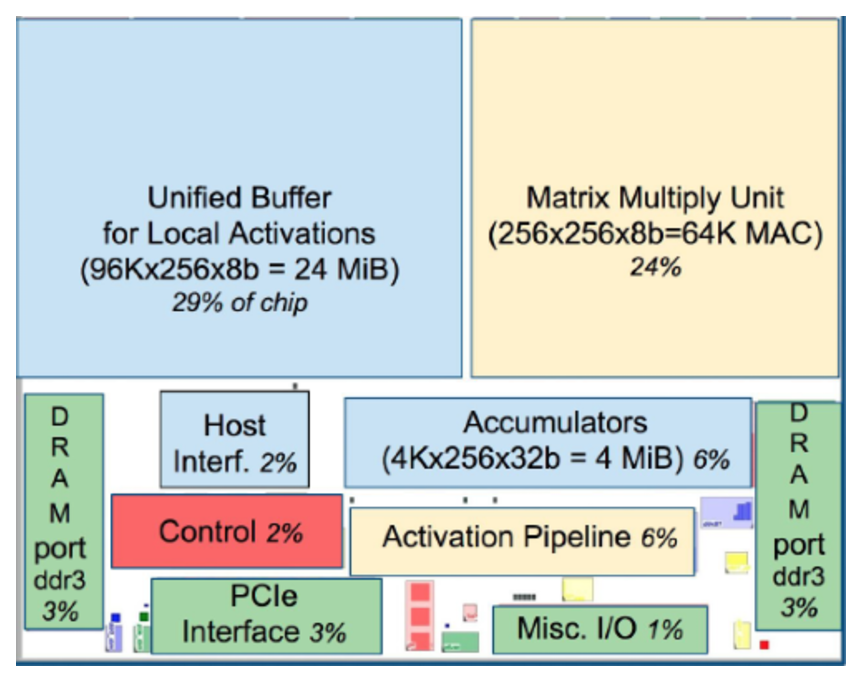

Google discovered inference work needs low latency more than high throughput. It also appreciated the choice to use a single-threaded design. “I find 18-threaded machines hard to think about,” said Young.

Asked what he would change, he said, “if I had it to do all over I would buy a real floating point unit and not worry about little problems that are still giving us bugs.”



# Amazon Soft FPGA

Xilinx VU9P chips on F1 Service. 

F1 service provides either one or eight FPGAs paired with eight or 64 CPUs, respectively. Each FPGA provides users with 64 GBytes memory, 2.5M logic elements and 6,800 DSPs. Amazon places multiple FPGAs on a 400 Gbits/s ring bus to enable streaming bandwidth.

Amazon’s FPGA Shell encapsulates the chip, its DDR4 memory controllers, PCIe links and the 400 Gbit/s interconnect. The company offers an SDK, including tools and APIs to program it.



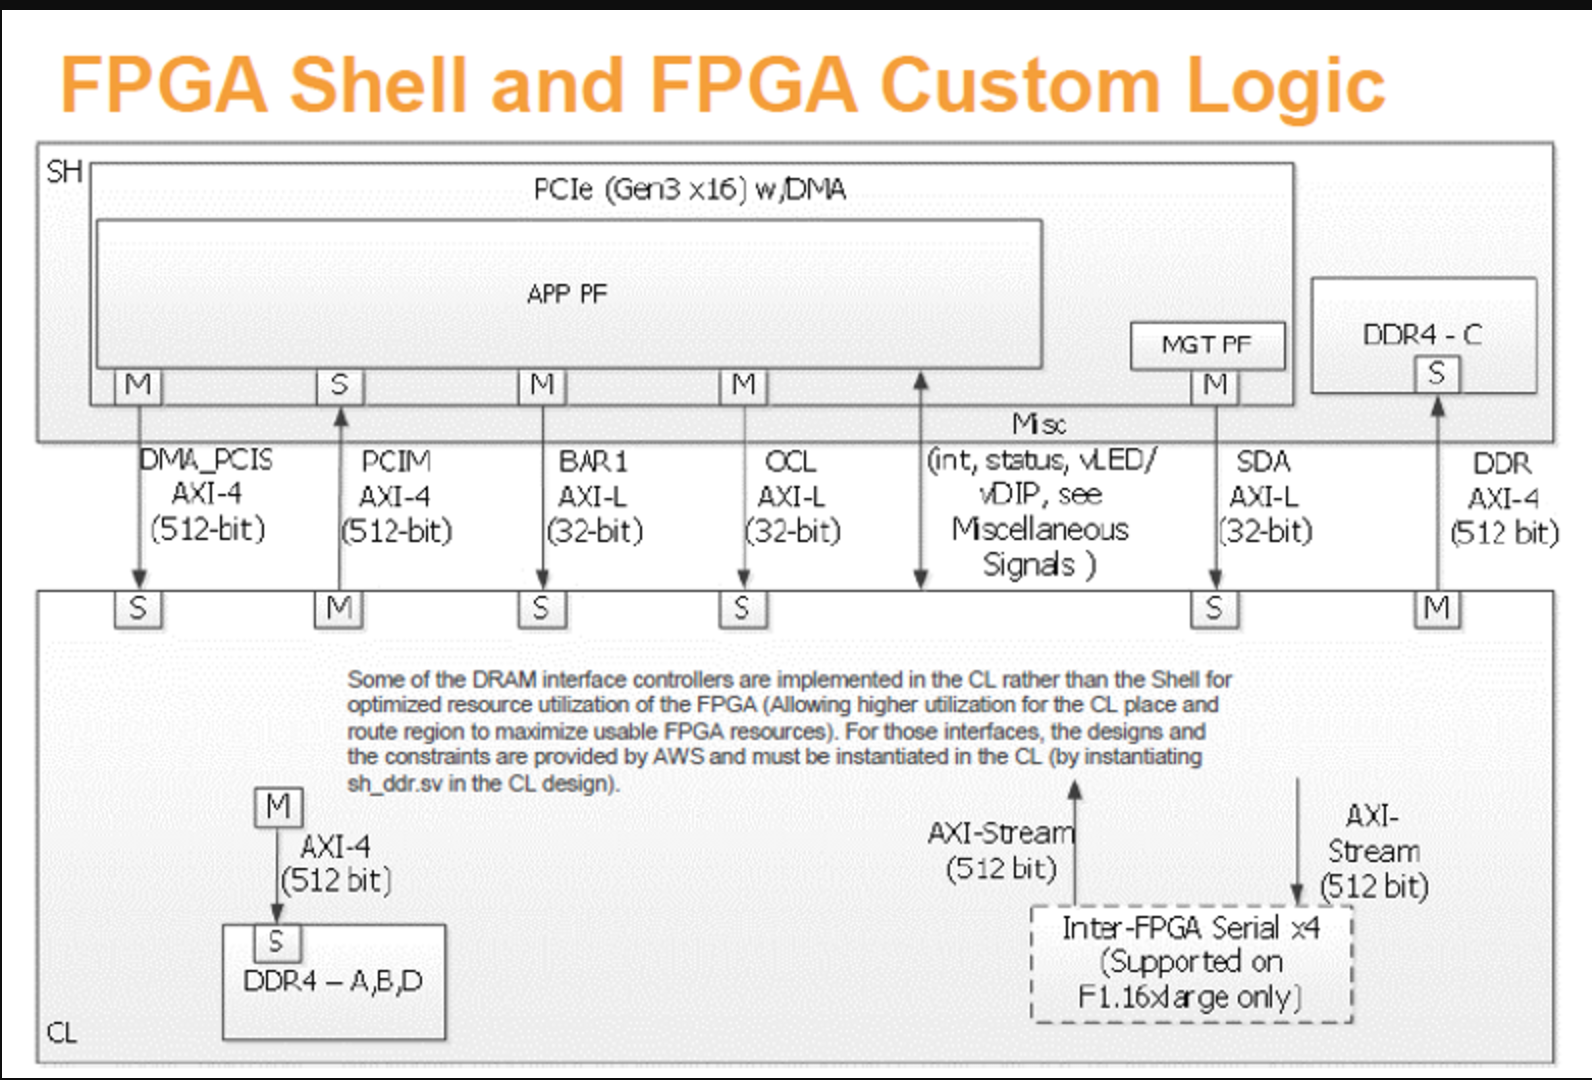

# Baidu 

In [596]:
baidu_XPU_small_CPU = {}
baidu_XPU_small_CPU["performance"] = "NA"
baidu_XPU_small_CPU["power_eff"] = "NA"
baidu_XPU_small_CPU["resolution"] = 'NA'
baidu_XPU_small_CPU["frequency"] = "NA"
baidu_XPU_small_CPU["memory"] = 'NA'
baidu_XPU_small_CPU["mac_count"] =  'NA'
baidu_XPU_small_CPU["transistor_count"] = 'NA'
baidu_XPU_small_CPU["DSP_count"] = 4
baidu_XPU_small_CPU["BRAM_count"] = 5
baidu_XPU_small_CPU["LUT_count"] = 1252
baidu_XPU_small_CPU["Reg_count"] = 1230
baidu_XPU_small_CPU["core_count"] = 32
baidu_XPU_small_CPU["FPGAorASIC"] = 'Xilinx_Virtex_Ultra_VU9P'

In [594]:
baidu_XPU_custom_logic = {}
baidu_XPU_custom_logic["performance"] = Q_(6.144,'teraops/s')
baidu_XPU_custom_logic["power_eff"] = "NA"
baidu_XPU_custom_logic["resolution"] = "16-Fixed"
baidu_XPU_custom_logic["frequency"] = Q_(600,'megahertz')
baidu_XPU_custom_logic["memory"] = 'NA'
baidu_XPU_custom_logic["mac_count"] =  'NA'
baidu_XPU_custom_logic["transistor_count"] = 'NA'
baidu_XPU_custom_logic["DSP_count"] = 5120
baidu_XPU_custom_logic["BRAM_count"] = 5
baidu_XPU_custom_logic["LUT_count"] = 1252
baidu_XPU_custom_logic["Reg_count"] = 1230
baidu_XPU_custom_logic["core_count"] = 32
baidu_XPU_custom_logic["FPGAorASIC"] = 'Xilinx_Virtex_Ultra_VU9P'

In [597]:
baidu = {}
baidu["performance"] = Q_(6.144,'teraops/s')
baidu["power_eff"] = "NA"
baidu["resolution"] = 'NA'
baidu["frequency"] = "NA"
baidu["memory"] = 'NA'
baidu["mac_count"] =  'NA'
baidu["transistor_count"] = 'NA'
baidu["core_count"] = 256
baidu["LUT_count"] = baidu_XPU_small_CPU["LUT_count"] * 256
baidu["DSP_count"] = baidu_XPU_small_CPU["DSP_count"] * 256
baidu["FPGAorASIC"] = 'XPU_Xilinx_Virtex_Ultra_VU9P'

Voice search service on about 3,000 servers with FPGAs. Altogether, it uses more than 10,000 FPGA cards today.



The device currently implemented in a Xilinx VU9P packs 256 tiny cores in 32-unit clusters running at a blazing 600 MHz. Each core contains 1,252 LUTs and four DSPs. It runs simple MIPS-like instructions with a bit of scratchpad memory

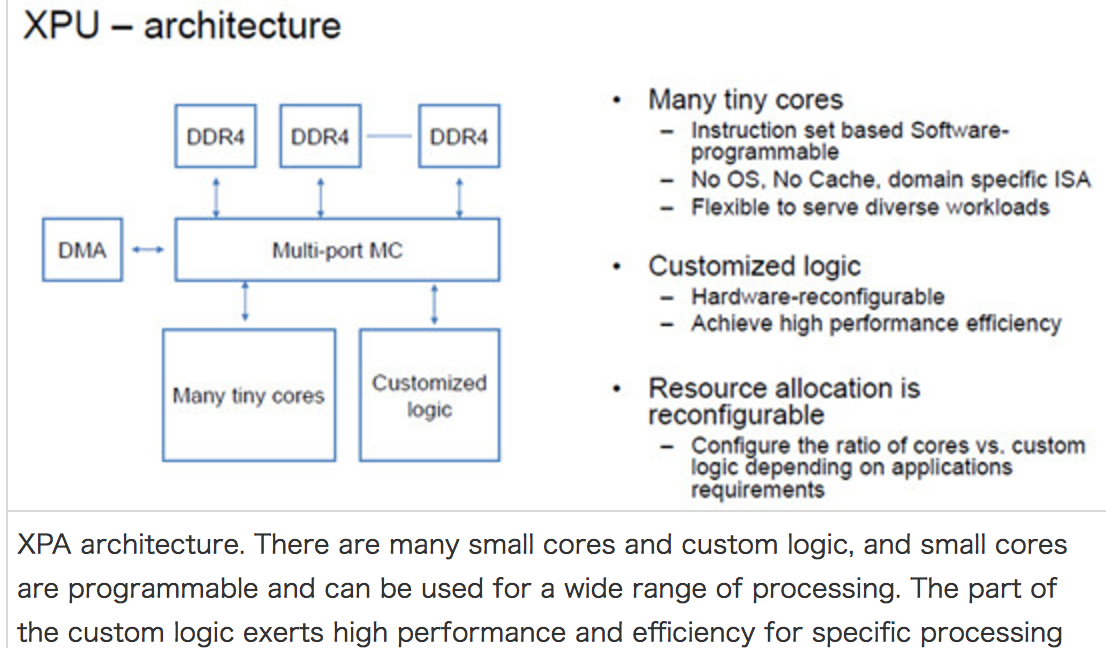

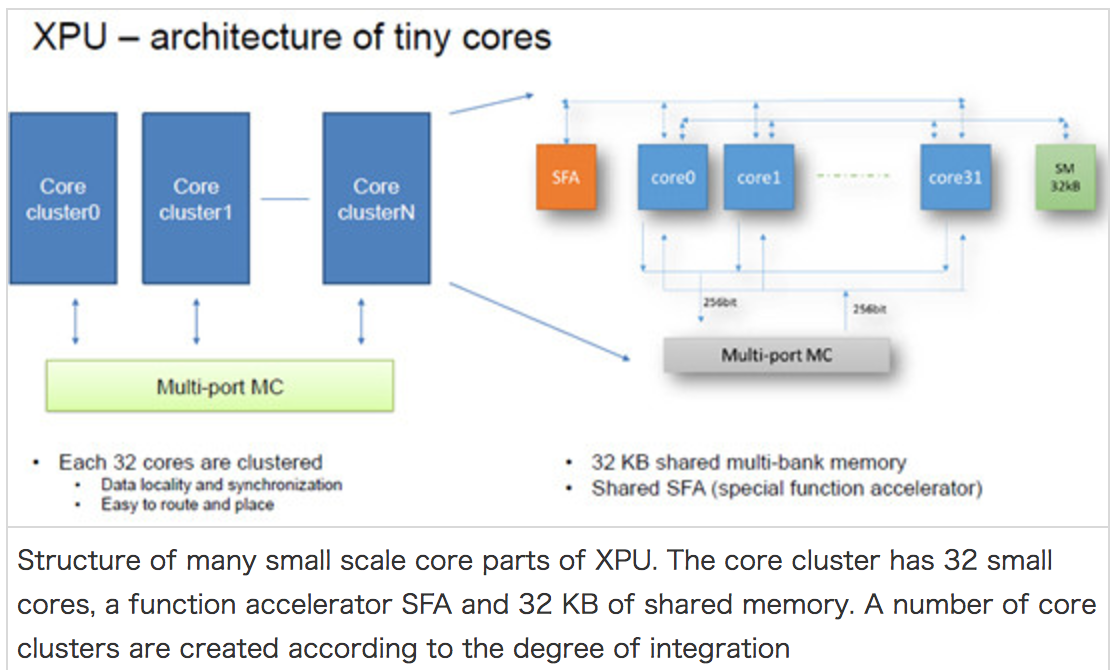

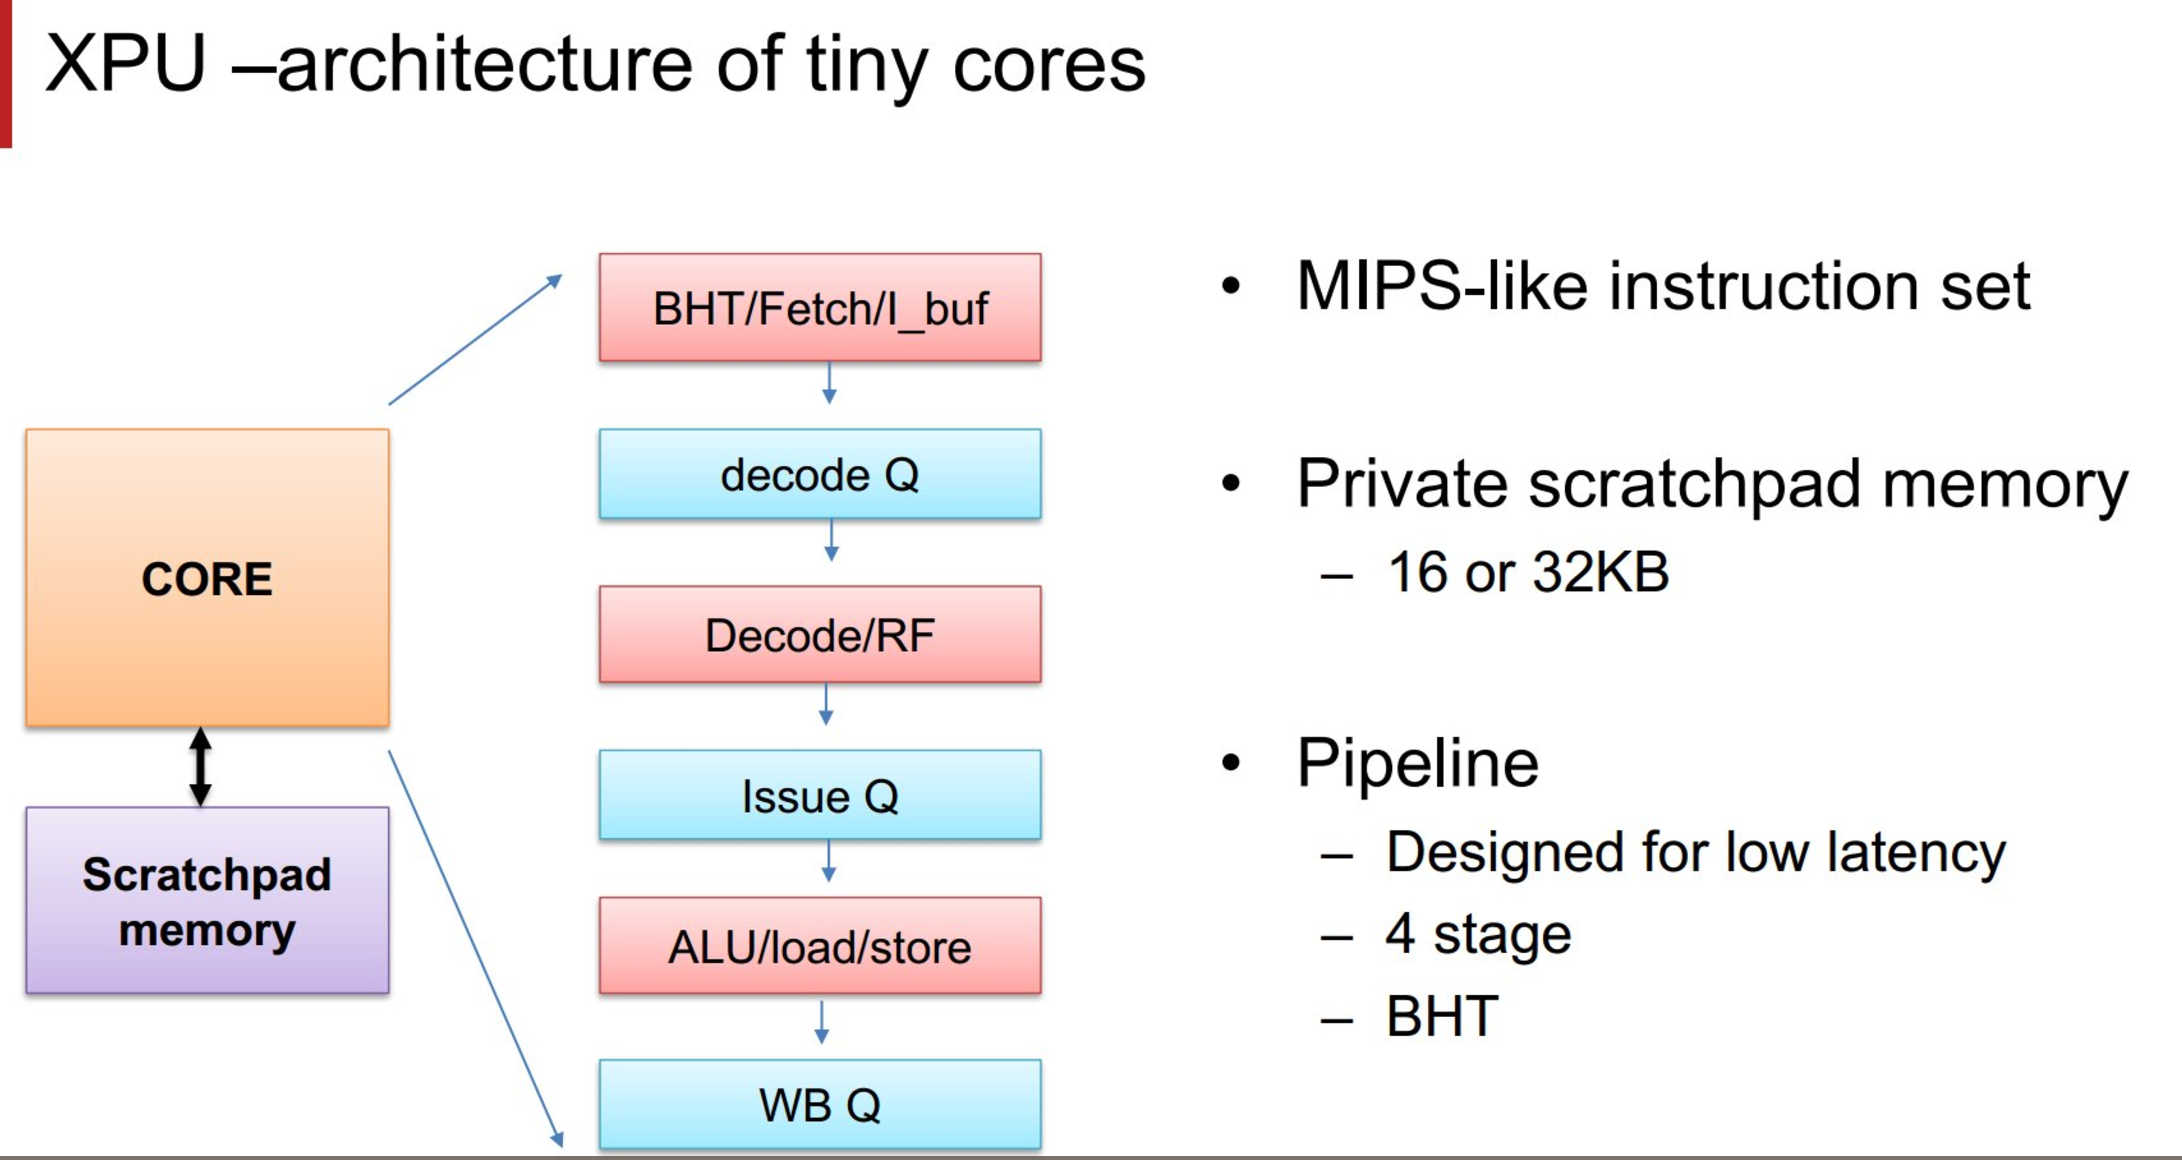

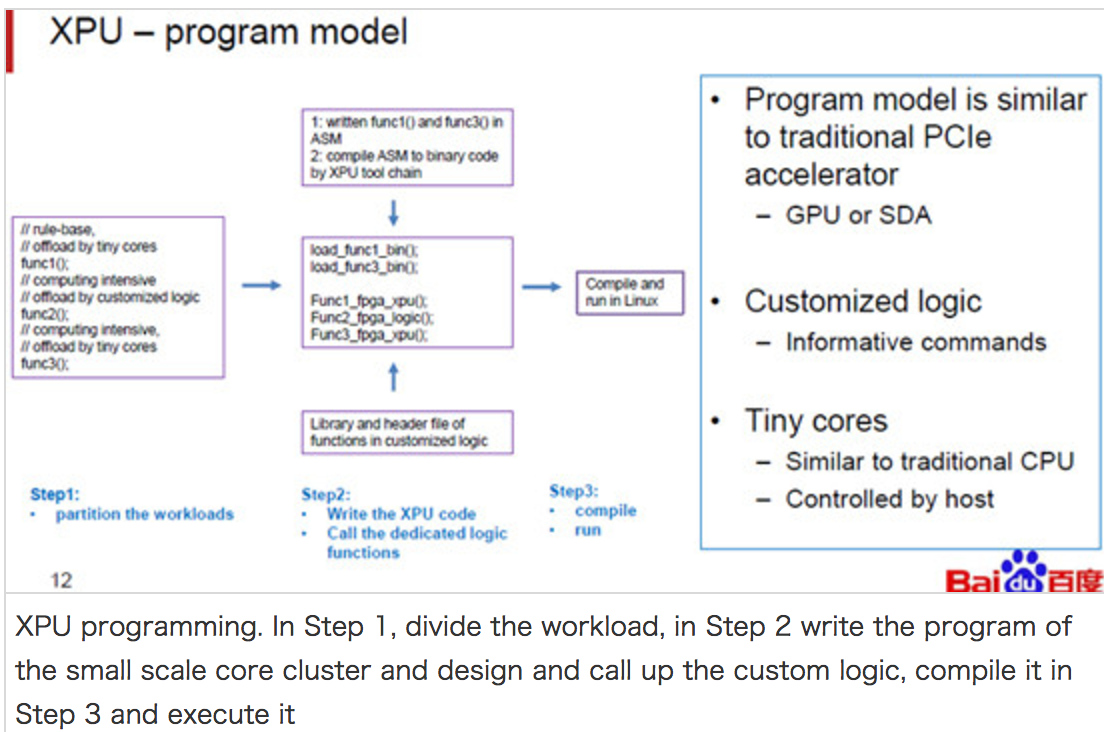

The chip acts as an accelerator with no operating system or cache. It rides a PCIe card and currently is programmed in assembler.

The XPU has access to four 72-bit banks of 2400 MHz DDR memory. The chip also contains custom logic to run Baidu’s SDA-II deep learning software at 6.144 TeraOps/second.



In [22]:
performance_flops["baidu"] = 6.144 # Teraops/s

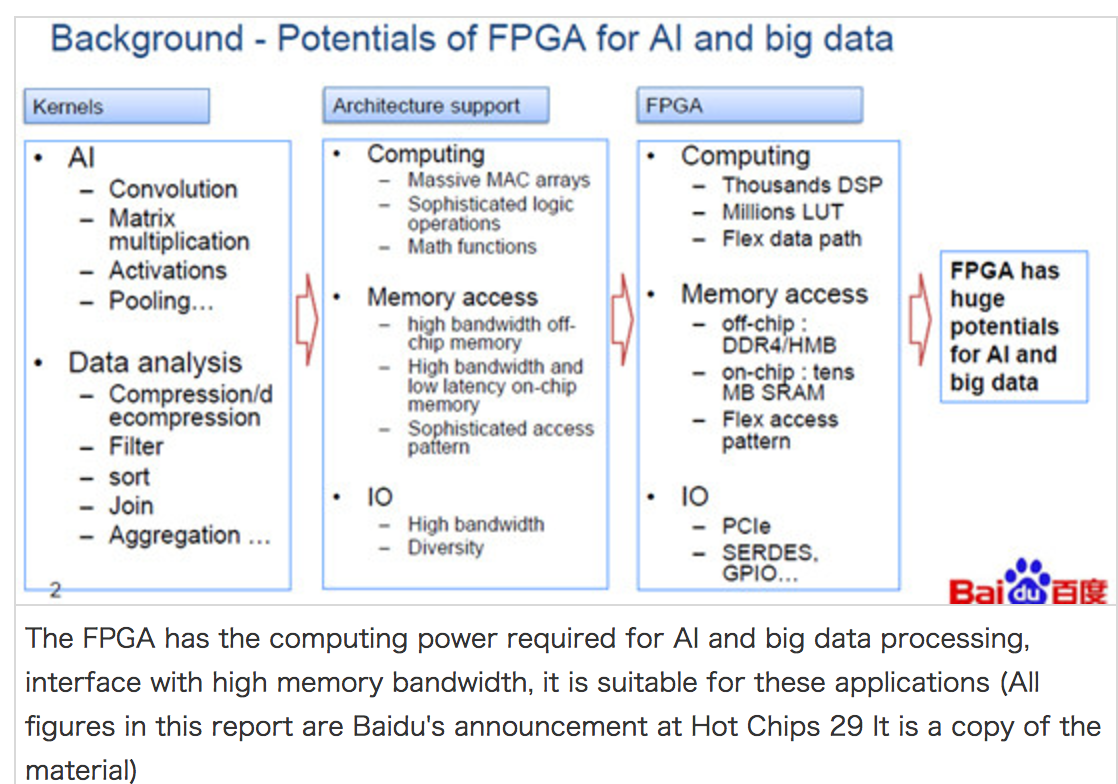

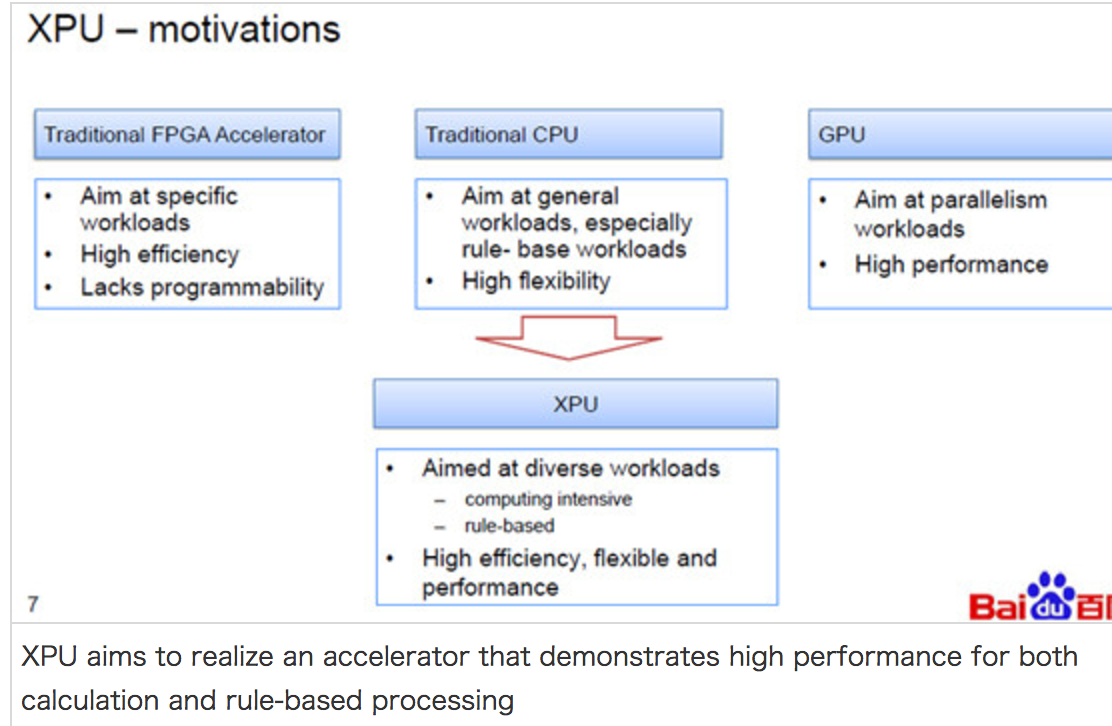

# Wave Computing

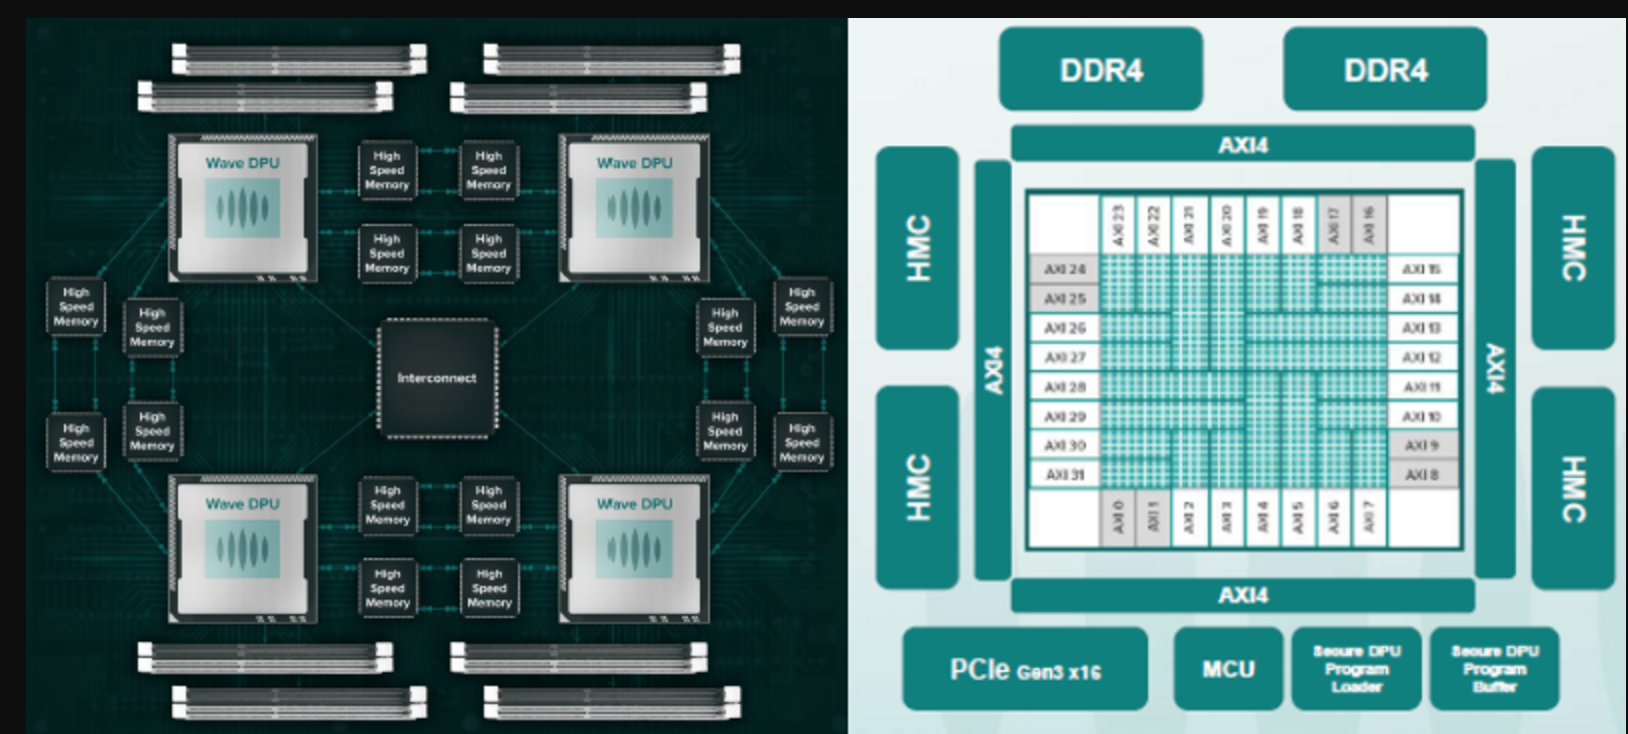

# Nvidia 

Nvidia’s Volta (below), announced in May, is nearly twice Vega’s size, a massive 815mm2. It more squarely targets the emerging market for neural network training that today is hungry for more performance.

Volta has 5,120 processors, 21 billion transistors, and can deliver up to 120 TFlops

In [23]:
processor_count["nvidia_volta"] = 5120
transistor_count["nvidia_volta"] = 21 #billion
performance_flops["nvidia_volta"] = 120 #Tflops

# AMD Vega

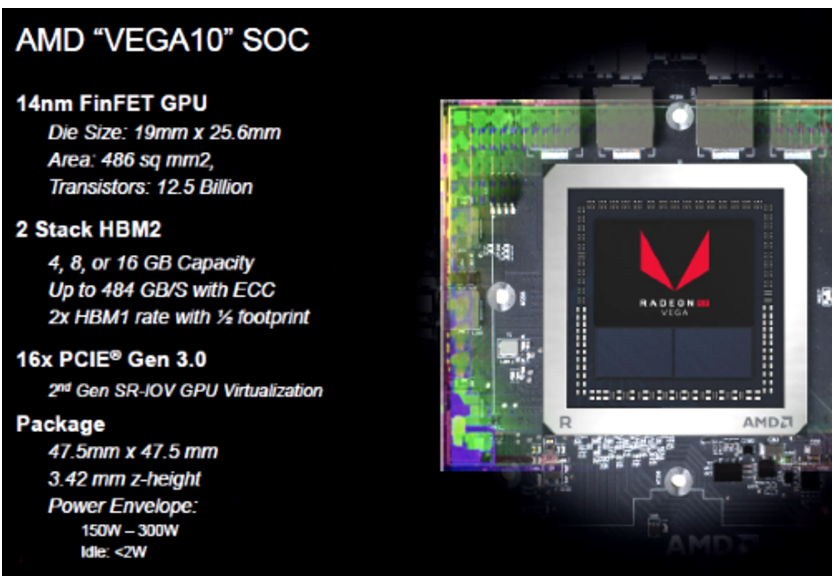

AMD said its Vega 10 (above), announced in January, is the first consumer chip to use HBM2 memory stacks and marks its return to the market for general-purpose GPU computing.



Vega has 4,096 processors, 12.5 billion transistors, and can deliver up to 26 TFlops

In [17]:
processor_count["amd_vega"] = 4096
transistor_count["amd_vega"] = 12.5 #billion
performance["amd_vega"] = 26 #TFlops

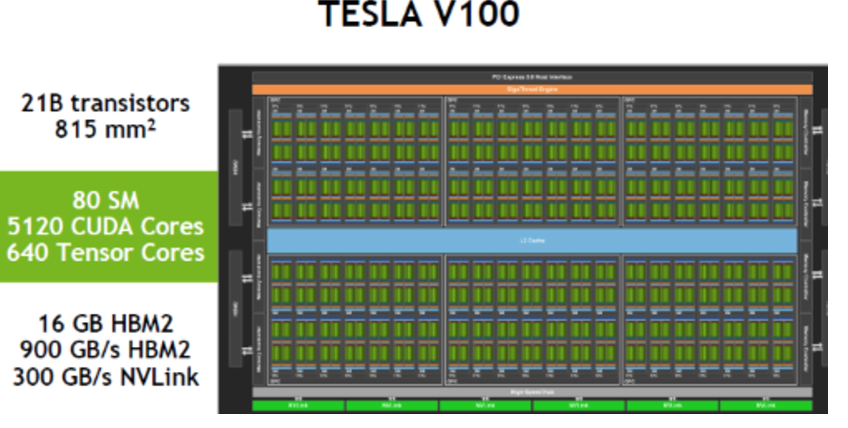

# Academic - Celerity

16nm TSMC PDK to tapeout of a 25mm2 device in nine months

Celerity packs into its 360 million transistors 511 RISC-V cores and a custom neural network accelerator. The cores are split into a 496-unit array running at 1.05 GHz and five Linux-capable Rocket cores along with the accelerator running at 625 MHz.


The students claim an astounding 700-1,220x speedup by using specialty and many-core tiers in collaboration, compared to using either in isolation. They expect first silicon in September.

The distributed team attributed its condensed design time and relatively miniscule $1.3 million budget to a mixture of factors. They relied heavily on open source IP and automated tools, and their design is highly modular. The teams hailed from Cornell, the University of Michigan and the Universities of California in Los Angeles and San Diego, supported by funds from DARPA.



# Summary 

In [587]:
accelerator_df = pd.DataFrame([brainwave_demo])

accelerator_df = accelerator_df.append([brainwave])
accelerator_df = accelerator_df.append([tpu1])

accelerator_df = accelerator_df.set_index('name')
accelerator_df

In [588]:
def change_dimension_float(series):
    if type(series["performance"]) != str:
        perf = float(series["performance"] * ureg.sec/ureg.teraops )
    else:
        perf = series["performance"]
    if type(series["power_eff"]) != str:
        pwr = float(series["power_eff"] * ureg.watt/ureg.gigaflops)
    else:
        pwr = series["power_eff"]
    print [perf,pwr]
    return [perf, pwr]

def change_dimension(series):
    if type(series["performance"]) != str:
        perf = series["performance"].to(ureg.teraops/ureg.sec)
    else:
        perf = series["performance"]
    if type(series["power_eff"]) != str:
        pwr = series["power_eff"].to(ureg.gigaflops/ureg.watt)
    else:
        pwr = series["power_eff"]
    print [perf,pwr]
    return [perf, pwr]

g = accelerator_df.apply(change_dimension, axis='columns')
accelerator_df["performance"] = [i[0] for i in g]
accelerator_df["power_eff"] = [i[1] for i in g]

[<Quantity(39.5, 'teraops / second')>, <Quantity(723, 'gigaflops / watt')>]
[<Quantity(90, 'teraops / second')>, 'NA']
[<Quantity(92, 'teraops / second')>, 'NA']


In [589]:
accelerator_df

FPGAorASIC      frequency    mac_count        memory  \
name                                                                  
brainwave_demo  stratix10  300 megahertz           NA            NA   
brainwave       stratix10  500 megahertz           NA            NA   
tpu1                 ASIC             NA  64 kilomacs  24 megabytes   

                          performance             power_eff processor_count  \
name                                                                          
brainwave_demo  39.5 teraops / second  723 gigaflops / watt              NA   
brainwave         90 teraops / second                    NA              NA   
tpu1              92 teraops / second                    NA              NA   

               resolution transistor_count  
name                                        
brainwave_demo     MS-FP8               NA  
brainwave          MS-FP8               NA  
tpu1                8-bit               NA

In [580]:
accelerator_df["mac_count"]

name
brainwave_demo             NA
brainwave                  NA
tpu1              64 kilomacs
Name: mac_count, dtype: object